In [56]:
# first import all necessary libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier

In [57]:
# read the training / test data 
training = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [58]:
# look through the features to get a good general overview about what data to expect 
training.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [59]:
# have a closer look at the dimensions and types of features 
print(training.shape)
training.info()

(891, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


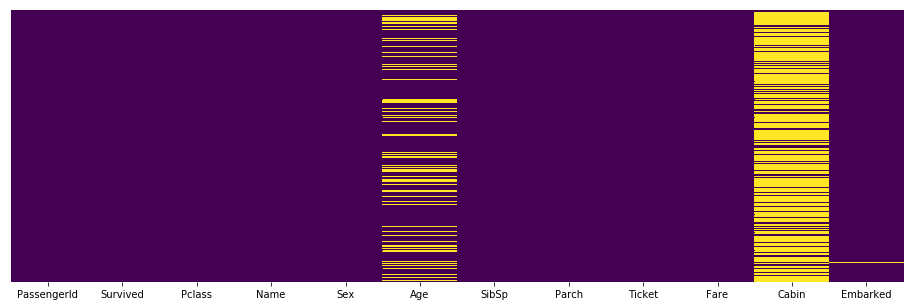

In [60]:
# we can see that the number of age and cabin entries seem to differ largely from the other features and the embarked feature has 2 missing values
# lets visualize the missing values in order to understand if there is a pattern to the absence of data
plt.figure(figsize = (16,5))
sns.heatmap(training.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [61]:
# we calculate the percentage of missing values for the two predominant features
def per_nan(df, cols):
    '''calculates the percentage of missing values for provided columns (cols) in a df'''
    for col in cols:
        percentage = (df[col].isnull().sum() / len(df[col])) * 100
        print('Percent of missing values in {0}: {1:.3}%'.format(col, percentage))
    return

per_nan(training, ['Age', 'Cabin'])

Percent of missing values in Age: 19.9%
Percent of missing values in Cabin: 77.1%


In [62]:
# as predicted a lot of values (77.1%) are missing in the cabin feature up to a point where imputing the values is not reasonable.
# we will drop the feature as a result, together with the identifiers (PassengerId, Name) and the Ticket feature (probably useless, way too many values)
def find_title(name):
    import re
    title = r', (\w+).'
    return re.findall(title, name)[0]
        


training['Title'] = training['Name'].apply(find_title)
test['Title'] = test['Name'].apply(find_title)
training = training.drop(['Cabin', 'Ticket', 'Name'], axis=1)
test = test.drop(['Cabin', 'Ticket', 'Name'], axis=1)


In [63]:
# the missing values in Age and Embarked feature can be imputed using the Sex/PClass features 
table = pd.pivot_table(training, values='Age', index=['Pclass', 'Sex'], aggfunc=np.nanmean)
table.head()

Age
Pclass Sex              
1      female  34.611765
       male    41.281386
2      female  28.722973
       male    30.740707
3      female  21.750000

In [64]:
# just to make sure we add an additional df where the nan's are deleted prior to calculation 
# however the difference is marginal
testing = training.dropna()
table = pd.pivot_table(testing, values='Age', index=['Pclass', 'Sex'], aggfunc=np.mean)
table.Age = table.Age.astype('int')
del testing
table.head()

Age
Pclass Sex        
1      female   34
       male     41
2      female   28
       male     30
3      female   21

In [65]:
# now we impute the ages with the Age-median of the corresponding Pclass / Sex features and group them in a new column ('Age_grouped')
def impute_age(df):
    testing = df.dropna()
    table = pd.pivot_table(df, values='Age', index=['Pclass', 'Sex'], aggfunc=np.median)
    table.Age = table.Age.astype('int')
    df[['Pclass','Sex','Age']] = df.set_index(['Pclass','Sex']).Age.fillna(table.Age).reset_index()
    df.Age = df.Age.astype('int')
    df['Age_grouped'] = pd.cut(df.Age, 5, labels=range(5))
    df['Age_grouped'] = df['Age_grouped'].astype('int')
    df = df.drop('Age', axis=1)
    return df

training = impute_age(training)
test = impute_age(test)
training.head()

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,Title,Age_grouped
0,1,0,3,male,1,0,7.2500,S,Mr,1
1,2,1,1,female,1,0,71.2833,C,Mrs,2
2,3,1,3,female,0,0,7.9250,S,Miss,1
3,4,1,1,female,1,0,53.1000,S,Mrs,2
4,5,0,3,male,0,0,8.0500,S,Mr,2


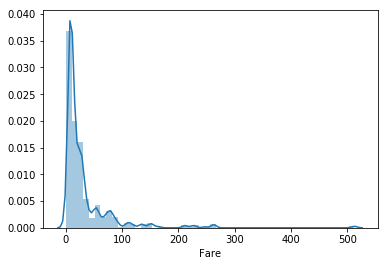

In [66]:
# We have only one feature with float values so let us look at the distribution of that feature ('Fare')
sns.distplot(training.Fare)

In [67]:
# for some reason the prediction of the test had an error indicating that a feature has 'nan' values 
# we use the info() method to determine which one it is
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Sex            418 non-null object
SibSp          418 non-null int64
Parch          418 non-null int64
Fare           417 non-null float64
Embarked       418 non-null object
Title          418 non-null object
Age_grouped    418 non-null int32
dtypes: float64(1), int32(1), int64(4), object(3)
memory usage: 27.8+ KB


In [68]:
# test.Fare has one missing value 
test.Fare = test.Fare.fillna(0)

In [69]:
# we also bin this feature since high values correlate with higher survival
for df in [training, test]:
    df['Fare_grouped'] = pd.cut(df['Fare'], 5, labels=range(5))
    df['Fare_grouped'] = df['Fare_grouped'].astype('int')

In [70]:
for item in [training, test]:
    item['Family'] = item['SibSp'] + item['Parch']

training = training.drop(['SibSp', 'Parch', 'PassengerId', 'Fare'], axis=1)

PassengerID = test['PassengerId']
test = test.drop(['SibSp', 'Parch', 'PassengerId', 'Fare'], axis=1) 

In [71]:
for dataset in [training,test]:
    dataset['Title'] = dataset['Title'].replace(['Lady', 
                                                 'Countess',
                                                 'Capt', 
                                                 'Col',
                                                 'Don', 
                                                 'Dr', 
                                                 'Major', 
                                                 'Rev', 
                                                 'Sir', 
                                                 'Jonkheer', 
                                                 'Dona',
                                                 'the'], 'other')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [72]:
# the categorical features are now transformed using one hot encoding.
#for item, col in zip([training, test], ['Fare']):
#training['Fare'] = pd.qcut(x=training['Fare'],  q=10, labels=range(10))
training = pd.get_dummies(training, columns=['Pclass', 'Sex', 'Embarked', 'Family', 'Title', 'Age_grouped', 'Fare_grouped'])
#test['Fare'] = pd.qcut(x=test['Fare'],  q=10, labels=range(10))
test = pd.get_dummies(test, columns=['Pclass', 'Sex', 'Embarked', 'Family', 'Title', 'Age_grouped', 'Fare_grouped'])

In [73]:
def split_into_xy(df):
    y = df['Survived']
    x = df.drop('Survived', axis=1)
    return (x,y)

x,y = split_into_xy(training)

training.head()

,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Family_0,...,Title_other,Age_grouped_0,Age_grouped_1,Age_grouped_2,Age_grouped_3,Age_grouped_4,Fare_grouped_0,Fare_grouped_1,Fare_grouped_2,Fare_grouped_4
0,0,0,0,1,0,1,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
1,1,1,0,0,1,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2,1,0,0,1,1,0,0,0,1,1,...,0,0,1,0,0,0,1,0,0,0
3,1,1,0,0,1,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
4,0,0,0,1,0,1,0,0,1,1,...,0,0,0,1,0,0,1,0,0,0


## Modeling

In [74]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.grid_search import GridSearchCV

In [75]:
models = []
models.append(('LR', LogisticRegression()))
#models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('RF', RandomForestClassifier()))
models.append(('XGB', XGBClassifier()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=291)
    cv_results = model_selection.cross_val_score(model, x, y, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "{}: {:.4} ({:.3})".format(name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.8294 (0.0388)
KNN: 0.8081 (0.0361)
CART: 0.8003 (0.0363)
NB: 0.6093 (0.0749)
SVM: 0.8103 (0.0404)
RF: 0.8059 (0.0401)
XGB: 0.8205 (0.0402)


In [76]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=291)
clf = LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                         intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
                         penalty='l1', random_state=291, solver='liblinear', tol=0.0001,
                         verbose=0, warm_start=False)

clf2 = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
       gamma=0, learning_rate=0.15, max_delta_step=0, max_depth=5,
       min_child_weight=10, missing=None, n_estimators=2000, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=291, silent=True, subsample=0.8)


'''
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
                     gamma=0, learning_rate=0.15, max_delta_step=0, max_depth=5,
                     min_child_weight=11, missing=None, n_estimators=1000, nthread=4,
                     objective='binary:logistic', reg_alpha=0, reg_lambda=1,
                    scale_pos_weight=1, seed=291, silent=True, subsample=0.8)
'''
clf3 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                              max_depth=5, max_features='auto', max_leaf_nodes=7,
                              min_impurity_decrease=0.0, min_impurity_split=None,
                              min_samples_leaf=1, min_samples_split=2,
                              min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                              oob_score=False, random_state=291, verbose=0,
                              warm_start=False)

clf4 = KNeighborsClassifier()

clf2.fit(X_train,y_train)
y_pred = clf2.predict(X_test)

In [77]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.78      0.87      0.82       160
          1       0.77      0.64      0.70       108

avg / total       0.78      0.78      0.77       268



In [78]:
from sklearn.metrics import accuracy_score
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 77.61%


In [79]:
clf.fit(x,y)
#training['LR_pred'] = clf.predict(training.drop('Survived', axis=1))
#test['LR_pred'] = clf.predict(test)
#clf2.fit(training.drop('Survived', axis=1),y)

C:\Users\M\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l1', random_state=291, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [80]:
df_submit = pd.DataFrame()
df_submit['PassengerId'] = PassengerID
df_submit['Survived'] = clf2.predict(test)

In [81]:
import pathlib
import datetime
filename  = datetime.datetime.now().strftime('%y%m%d') + '_submission.csv'
filefolder = './submissions/'
submission = pathlib.Path(filefolder+filename)
if submission.is_file():
    filename  = datetime.datetime.now().strftime('%y%m%d_%H%M_') + '_submission.csv'
    df_submit.to_csv(filefolder + filename, header=['PassengerId', 'Survived'], index=False)
    
else:
    df_submit.to_csv(filefolder + filename, header=['PassengerId', 'Survived'], index=False)